<font size = 6 color = 'green'> Empirical Orthogonal Function

<font size = 4> Autor original: Ing. Manuel Figueroa Culqui (docente del curso "METEOROLOGÍA TROPICAL" - UNALM)

<font size = 4> Modificado por: Est. Kevin Campos Sánchez

In [ ]:
##### CONFIGURACIÓN DE ENTORNO #####
import numpy as np, matplotlib.pyplot as plt, xarray as xr, seaborn as sns, pandas as pd, os, sys
from google.colab import drive        # Conectar Google drive
drive.mount('/content/drive/')

path = '/content/drive/MyDrive/Trabajos_UNALM/M. Tropical/P6_MTropical/'      # Directorio de trabajo
os.chdir(path)         # Seleccionar carpeta de trabajo

Mounted at /content/drive/


###<font size = 4 color = 'green'> Ejercicio 1
Se tienen 10 años de promedios anuales de temperatura del aire de 4 estaciones meteorólógicas ubicadas una zona ”X”, comprenden las zonas Nor Oeste (NO), Sur Oeste(SO), Nor Este (NE) y Sur Este.


In [ ]:
T1 = [10,14,14,14,10,10,14,10,14,10]
T2 = [13,17,17,19,18,19,12,14,16,17]
T3 = [18,16,16,15,15,16,20,19,18,15]
T4 = [15,18,18,18,16,16,14,14,15,15]

T = pd.DataFrame({'NO':T1,'NE':T2,'SO':T3,'SE':T4}, index = range(1,10+1))
T

,NO,NE,SO,SE
1,10,13,18,15
2,14,17,16,18
3,14,17,16,18
4,14,19,15,18
5,10,18,15,16
6,10,19,16,16
7,14,12,20,14
8,10,14,19,14
9,14,16,18,15
10,10,17,15,15


1. Grafique las series de tiempo de las 4 estaciones

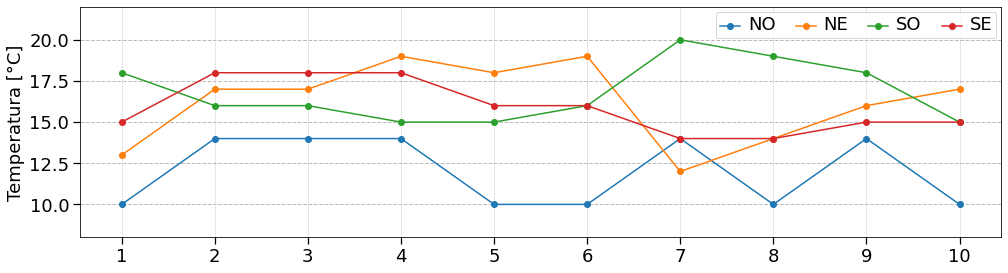

In [ ]:
fig, ax = plt.subplots(figsize = (16,4))
T.plot(ax = ax, style = 'o-', xticks = range(1,10+1), ylim = (8,22))
ax.set_ylabel('Temperatura [°C]', fontsize = 18)
ax.yaxis.grid(ls = '--', lw = 1, color = '#BBBBBB', zorder = 1)
ax.xaxis.grid(ls = '--', lw = 0.5, color = '#BBBBBB', zorder = 1)
ax.tick_params('both', length = 7, width = 1.25, labelsize = 18)

sns.move_legend(ax, loc='upper right')
plt.legend(ncol=4)
plt.setp(ax.get_legend().get_texts(), fontsize='18')

plt.subplots_adjust(bottom = 0.1, top = 0.9, left = 0.1, right = 0.9, wspace = 0., hspace = 0.)

fig.savefig(path + 'E1_T Lineplot.png', transparent = False, 
            pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

2. Calcule las anomalías de temperatura:   $𝑇′𝑖 = 𝑇𝑖 − 𝑇_{avg}$

In [ ]:
Tavg = T.mean(axis = 0).to_frame().T

# Nota: aprovechamos el broascasting de los arrays para 
#       calcular las anomalías en todas las filas
Tanom = T.values - Tavg.values      # Anomalías como numpy.array

Tanom_df = pd.DataFrame(Tanom, index = T.index, columns = T.columns)
Tanom_df    # Anomalías como pandas.DataFrame

,NO,NE,SO,SE
1,-2.0,-3.2,1.2,-0.9
2,2.0,0.8,-0.8,2.1
3,2.0,0.8,-0.8,2.1
4,2.0,2.8,-1.8,2.1
5,-2.0,1.8,-1.8,0.1
6,-2.0,2.8,-0.8,0.1
7,2.0,-4.2,3.2,-1.9
8,-2.0,-2.2,2.2,-1.9
9,2.0,-0.2,1.2,-0.9
10,-2.0,0.8,-1.8,-0.9


3. Calcule la matriz de covarianza de las anomalías y determine la varianza total de los datos (traza de la matriz de covarianza)


In [ ]:
def Covar(Array):
    N,M = Array.shape
    cov = np.zeros(shape = (M,M))

    for i in range(M):
        for j in range(M):
            cov[i,j] = (1/N) * np.sum(Array[:,i] * Array[:,j])
    return cov
MC = Covar(Tanom)
MC

array([[ 4.  ,  0.  ,  0.4 ,  1.4 ],
       [ 0.  ,  5.36, -3.56,  2.42],
       [ 0.4 , -3.56,  2.96, -1.82],
       [ 1.4 ,  2.42, -1.82,  2.29]])

In [ ]:
# Mismo resultado si usaramos:
Tanom_df.cov(ddof = 0)

,NO,NE,SO,SE
NO,4.0,0.00,0.40,1.40
NE,0.0,5.36,-3.56,2.42
SO,0.4,-3.56,2.96,-1.82
SE,1.4,2.42,-1.82,2.29


4 y 5. Calcule los valores propios y vectores propios de la matriz de covarianza

In [ ]:
eigval, eigvec = np.linalg.eigh(MC, UPLO = 'U')
order = np.argsort(eigval)[::-1]    # Orden de mayor a menor eigenvalor
eigval, eigvec = eigval[order], eigvec[:,order]
eigval, eigvec

(array([9.25987104, 4.52945601, 0.58663805, 0.23403489]),
 array([[ 0.06845631,  0.92872122, -0.23070763,  0.282072  ],
        [ 0.73877112, -0.12684041, -0.60885692, -0.25965745],
        [-0.53128096,  0.17514618, -0.36342233, -0.74497555],
        [ 0.40898839,  0.30118469,  0.66632684, -0.5459165 ]]))

6. Encuentre los Componentes principales

$$𝑃𝐶_{(𝑘, 𝑖)} = \sum_{𝑗=1}^{K} [𝑎𝑢𝑡𝑜𝑣𝑒𝑐𝑡𝑜𝑟_{(𝑘, 𝑗)} ∗ 𝑇_{(𝑗, 𝑖)}]$$


In [ ]:
def PC(Array, Eigvec):
    N,M = Array.shape   # nrow, ncol = n° dims, n° vector
    pc = np.zeros(shape = (N,M))
    for k in range(M):
        for j in range(N):
            pc[j,k] = np.sum( np.transpose(eigvec[:,k]) * Array[j,:] )
    return pc

CPrincipales = PC(T.values, eigvec)

In [ ]:
CPrincipales_df = pd.DataFrame(CPrincipales, columns = ['PC1','PC2','PC3','PC4'])
CPrincipales_df

,PC1,PC2,PC3,PC4
0,6.860356,15.308688,-6.768916,-22.153134
1,12.378793,19.069473,-7.401349,-22.211274
2,12.378793,19.069473,-7.401349,-22.211274
3,14.387616,18.640646,-8.255640,-21.985614
4,12.557043,14.450233,-8.056606,-21.762411
5,12.764533,14.498538,-9.028886,-22.767044
6,4.923860,19.199521,-8.476061,-21.709223
7,6.658858,15.055810,-8.407522,-22.611851
8,9.350495,18.643052,-9.518317,-21.803819
9,11.409284,14.275888,-8.114076,-20.956837


7. Grafique los componentes principales

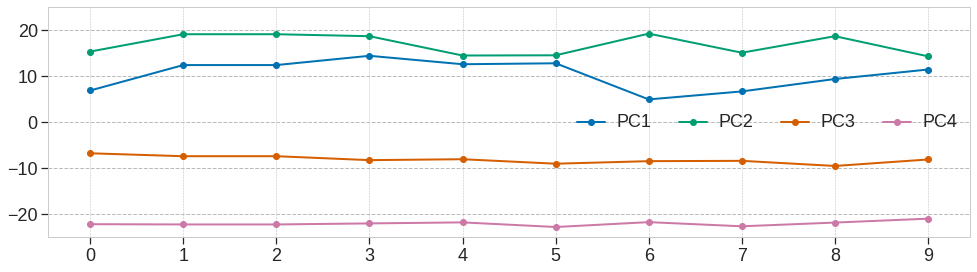

In [ ]:
fig, ax = plt.subplots(figsize = (16,4))
CPrincipales_df.plot(ax = ax, style = 'o-', xticks = range(10), ylim = (-25,25))
ax.yaxis.grid(ls = '--', lw = 1, color = '#BBBBBB', zorder = 1)
ax.xaxis.grid(ls = '--', lw = 0.5, color = '#BBBBBB', zorder = 1)
ax.tick_params('both', length = 7, width = 1.25, labelsize = 18)

sns.move_legend(ax, loc='upper right')
plt.legend(ncol=4)
plt.setp(ax.get_legend().get_texts(), fontsize='18')

plt.subplots_adjust(bottom = 0.1, top = 0.9, left = 0.1, right = 0.9, wspace = 0., hspace = 0.)

fig.savefig(path + 'E7_T CPrincipales.png', transparent = False, 
            pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

8. ¿Qué porcentaje de la varianza total de los datos es explicada por el PC1 y PC2?

In [ ]:
sum_eigval = np.sum(eigval)
var_explicada = np.array([ev * 100 / sum_eigval for ev in eigval])
var_explicada

array([63.38036304, 31.00243678,  4.01531863,  1.60188155])

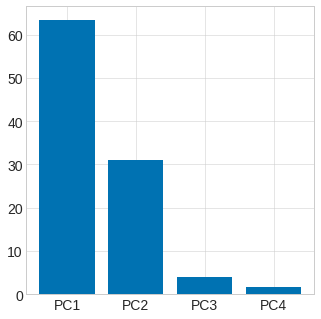

In [ ]:
# plt.style.use('default')
plt.style.use('seaborn-whitegrid')

fig,ax = plt.subplots(figsize = (5,5))
ax.bar(x = ['PC1','PC2','PC3','PC4'], height = var_explicada)

plt.subplots_adjust(bottom = 0.1, top = 0.9, left = 0.1, right = 0.9, wspace = 0., hspace = 0.)
fig.savefig(path + 'E8_T CP_var.png', transparent = False, 
            pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

9. Reconstruya las series de Temperatura, empleando la PC1 y la PC2. Siendo PC1 el
que explica la mayor varianza de los datos y PC2 el que le sigue
$$𝑇𝑘_{(𝑗, 𝑖)} = 𝑎𝑢𝑡𝑜𝑣𝑒𝑐𝑡𝑜𝑟_{(𝑘, 𝑗)} ∗ 𝑃𝐶_{(𝑘, 𝑖)}$$


In [ ]:
def Sintesis(Array, Eigvec, CP_matrix, cp):
    N,M = Array.shape
    R = np.zeros_like(Array, dtype = float)
    for j in range(M):
        for i in range(N):
            R[i,j] = Eigvec[j,cp-1] * CP_matrix[i,cp-1]
    return R

Tr_1 = Sintesis(T.values, eigvec, CPrincipales, 1)
Tr_2 = Sintesis(T.values, eigvec, CPrincipales, 2)
Tr_1

array([[ 0.46963466,  5.06823306, -3.64477663,  2.805806  ],
       [ 0.84740647,  9.14509483, -6.57661704,  5.06278256],
       [ 0.84740647,  9.14509483, -6.57661704,  5.06278256],
       [ 0.98492309, 10.62915541, -7.64386657,  5.88436792],
       [ 0.85960882,  9.27678084, -6.67131792,  5.13568477],
       [ 0.87381283,  9.43006858, -6.78155349,  5.22054584],
       [ 0.33706928,  3.63760558, -2.61595307,  2.01380155],
       [ 0.45584084,  4.91937199, -3.53772446,  2.72339557],
       [ 0.64010036,  6.90787556, -4.96773986,  3.82424377],
       [ 0.78103744,  8.42884925, -6.06153514,  4.66626447]])

In [ ]:
Tr_1_df = pd.DataFrame(Tr_1, T.index, T.columns)
Tr_2_df = pd.DataFrame(Tr_2, T.index, T.columns)
Tr_1_df

,NO,NE,SO,SE
1,0.469635,5.068233,-3.644777,2.805806
2,0.847406,9.145095,-6.576617,5.062783
3,0.847406,9.145095,-6.576617,5.062783
4,0.984923,10.629155,-7.643867,5.884368
5,0.859609,9.276781,-6.671318,5.135685
6,0.873813,9.430069,-6.781553,5.220546
7,0.337069,3.637606,-2.615953,2.013802
8,0.455841,4.919372,-3.537724,2.723396
9,0.640100,6.907876,-4.967740,3.824244
10,0.781037,8.428849,-6.061535,4.666264


10. Grafique las series reconstruidas y analice las diferencias entre ambos resultados

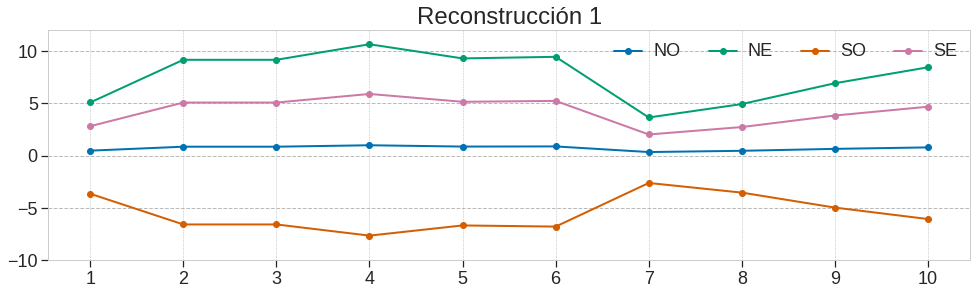

In [ ]:
fig, ax = plt.subplots(figsize = (16,4))
Tr_1_df.plot(ax = ax, style = 'o-', xticks = range(1,10+1), ylim = (-10,12))
ax.yaxis.grid(ls = '--', lw = 1, color = '#BBBBBB', zorder = 1)
ax.xaxis.grid(ls = '--', lw = 0.5, color = '#BBBBBB', zorder = 1)
ax.tick_params('both', length = 7, width = 1.25, labelsize = 18)

sns.move_legend(ax, loc='upper right')
plt.legend(ncol=4)
plt.setp(ax.get_legend().get_texts(), fontsize='18')
ax.set_title('Reconstrucción 1', fontsize = 24)

plt.subplots_adjust(bottom = 0.1, top = 0.9, left = 0.1, right = 0.9, wspace = 0., hspace = 0.)

fig.savefig(path + 'E10_T Tr1.png', transparent = False, 
            pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

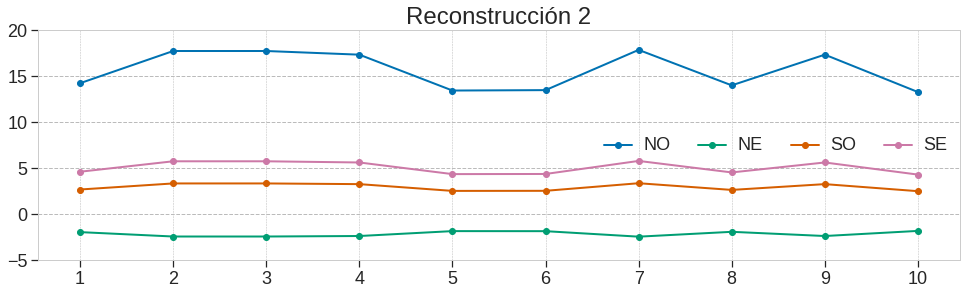

In [ ]:
fig, ax = plt.subplots(figsize = (16,4))
Tr_2_df.plot(ax = ax, style = 'o-', xticks = range(1,10+1), ylim = (-5,20))
ax.yaxis.grid(ls = '--', lw = 1, color = '#BBBBBB', zorder = 1)
ax.xaxis.grid(ls = '--', lw = 0.5, color = '#BBBBBB', zorder = 1)
ax.tick_params('both', length = 7, width = 1.25, labelsize = 18)

sns.move_legend(ax, loc='upper right')
plt.legend(ncol=4)
plt.setp(ax.get_legend().get_texts(), fontsize='18')
ax.set_title('Reconstrucción 2', fontsize = 24)

plt.subplots_adjust(bottom = 0.1, top = 0.9, left = 0.1, right = 0.9, wspace = 0., hspace = 0.)

fig.savefig(path + 'E10_T Tr2.png', transparent = False, 
            pad_inches = 0.1, dpi = 400, bbox_inches = 'tight')

In [ ]:
""" Código en Scilab in cloud (https://cloud.scilab.in/)
//Rpta 1:
T=[10 13 18 15;14 17 16 18;14 17 16 18;14 19 15 18;10 18 15 16;10 19 16 16;14 12 20 14;10 14 19 14;14 16 18 15;10 17 15 15]

// Rpta 2:
Tp=mean(T,'r')
A=zeros (10,4)
for i=1:10
	A(i,:)=T(i,:)-Tp
	end
    
// Rpta 3:
function [covariN]=covari(A,j)
	//N=size(A)(1)  // Esta parte debería dar 10, pero da 2 ¿error?
    N = 10
	covariN = zeros(j,j)
    for ifor= 1:j
		for jfor= 1:j
			covariN(ifor ,jfor)=(1/N)*sum(A(:,ifor).*A(:,jfor))
		end
	end
endfunction

MC= covari(A,4) // 4 porq son 4 estaciones
tMC=trace(MC)

//	Demostración del error
//function [N]=NA(A)
//	N = size(A)(1)	// Da 2
//endfunction
//NA(A)

[vec,val] = spec(MC)
valvec=gsort([diag(val)';vec], "lc", "d") // De mayor a menor de acuerdo a autovalores
autoval=valvec (1,:)
autovec=valvec (2:5 ,:)

function [PC]=pc(i,k,autov)
	PC= zeros(i,k)
	for ik= 1:k
		for ii= 1:i
			//disp(ik)
            //disp(ii)
            PC(ii,ik)=sum(autov(:,ik)'.*T(ii ,:))
		end
	end
endfunction

pc_all=pc(10,4, autovec)
            
PC1=autoval (:,1)*100/ sum(autoval)
PC2=autoval (:,2)*100/ sum(autoval)
PC3=autoval (:,3)*100/ sum(autoval)
PC4=autoval (:,4)*100/ sum(autoval)

//plot(pc_all (:,1),'r' )
//plot(pc_all (:,2),'g')
//plot(pc_all (:,3),'b')
//plot(pc_all (:,4),'k')
//ylabel('T (C)')
//legend('patron 1','patron 2','patron 3','patron 4')

function [Tr]= sintesis(Npc ,i,j)
  Tr=zeros(i,j)
  for nj=1:j
      for ni=1:i
          Tr(ni,nj) =autovec(nj,Npc).*pc_all(ni,Npc)
      end
  end
endfunction

Tr1=sintesis (1,10,4) 
"""